# L5: Automate Event Planning

In this lesson, you will learn more about Tasks.

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, APIs and LLM

In [2]:
from crewai import Agent, Crew, Task

**Note**: 
- The video uses `gpt-4-turbo`, but due to certain constraints, and in order to offer this course for free to everyone, the code you'll run here will use `gpt-3.5-turbo`.
- You can use `gpt-4-turbo` when you run the notebook _locally_ (using `gpt-4-turbo` will not work on the platform)
- Thank you for your understanding!

In [3]:
import os
from utils import get_openai_api_key,get_serper_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["SERPER_API_KEY"] = get_serper_api_key()

## crewAI Tools

In [4]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool() ## Search internet using google
scrape_tool = ScrapeWebsiteTool() ## Go into the website that serper find and scrape the context form website

## Creating Agents

In [5]:
# Agent 1: Venue Coordinator
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue "
    "based on event requirements",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "With a keen sense of space and "
        "understanding of event logistics, "
        "you excel at finding and securing "
        "the perfect venue that fits the event's theme, "
        "size, and budget constraints."
    )
)

In [6]:
 # Agent 2: Logistics Manager
logistics_manager = Agent(
    role='Logistics Manager',
    goal=(
        "Manage all logistics for the event "
        "including catering and equipmen"
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, "
        "you ensure that every logistical aspect of the event "
        "from catering to equipment setup "
        "is flawlessly executed to create a seamless experience."
    )
)

In [7]:
# Agent 3: Marketing and Communications Agent
marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Effectively market the event and "
         "communicate with participants",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, "
        "you craft compelling messages and "
        "engage with potential attendees "
        "to maximize event exposure and participation."
    )
)

## Creating Venue Pydantic Object

- Create a class `VenueDetails` using [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/).
- Agents will populate this object with information about different venues by creating different instances of it.

In [8]:
from pydantic import BaseModel
# Define a Pydantic model for venue details 
# (demonstrating Output as Pydantic)
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

## Creating Tasks
- By using `output_json`, you can specify the structure of the output you want.
- By using `output_file`, you can get your output in a file.
- By setting `human_input=True`, the task will ask for human feedback (whether you like the results or not) before finalising it.

In [9]:
venue_task = Task(
    description="Find a venue in {event_city} "
                "that meets criteria for {event_topic}.",
    expected_output="All the details of a specifically chosen"
                    "venue you found to accommodate the event.",
    human_input=True,
    output_json=VenueDetails,
    output_file="venue_details.json",  
      # Outputs the venue details as a JSON file
    agent=venue_coordinator
)

- By setting `async_execution=True`, it means the task can run in parallel with the tasks which come after it.

In [10]:
logistics_task = Task(
    description="Coordinate catering and "
                 "equipment for an event "
                 "with {expected_participants} participants "
                 "on {tentative_date}.",
    expected_output="Confirmation of all logistics arrangements "
                    "including catering and equipment setup.",
    human_input=True,
    async_execution=True,
    agent=logistics_manager
)

In [11]:
marketing_task = Task(
    description="Promote the {event_topic} "
                "aiming to engage at least"
                "{expected_participants} potential attendees.",
    expected_output="Report on marketing activities "
                    "and attendee engagement formatted as markdown.",
    async_execution=True,
    output_file="marketing_report.md",  # Outputs the report as a text file
    agent=marketing_communications_agent
)

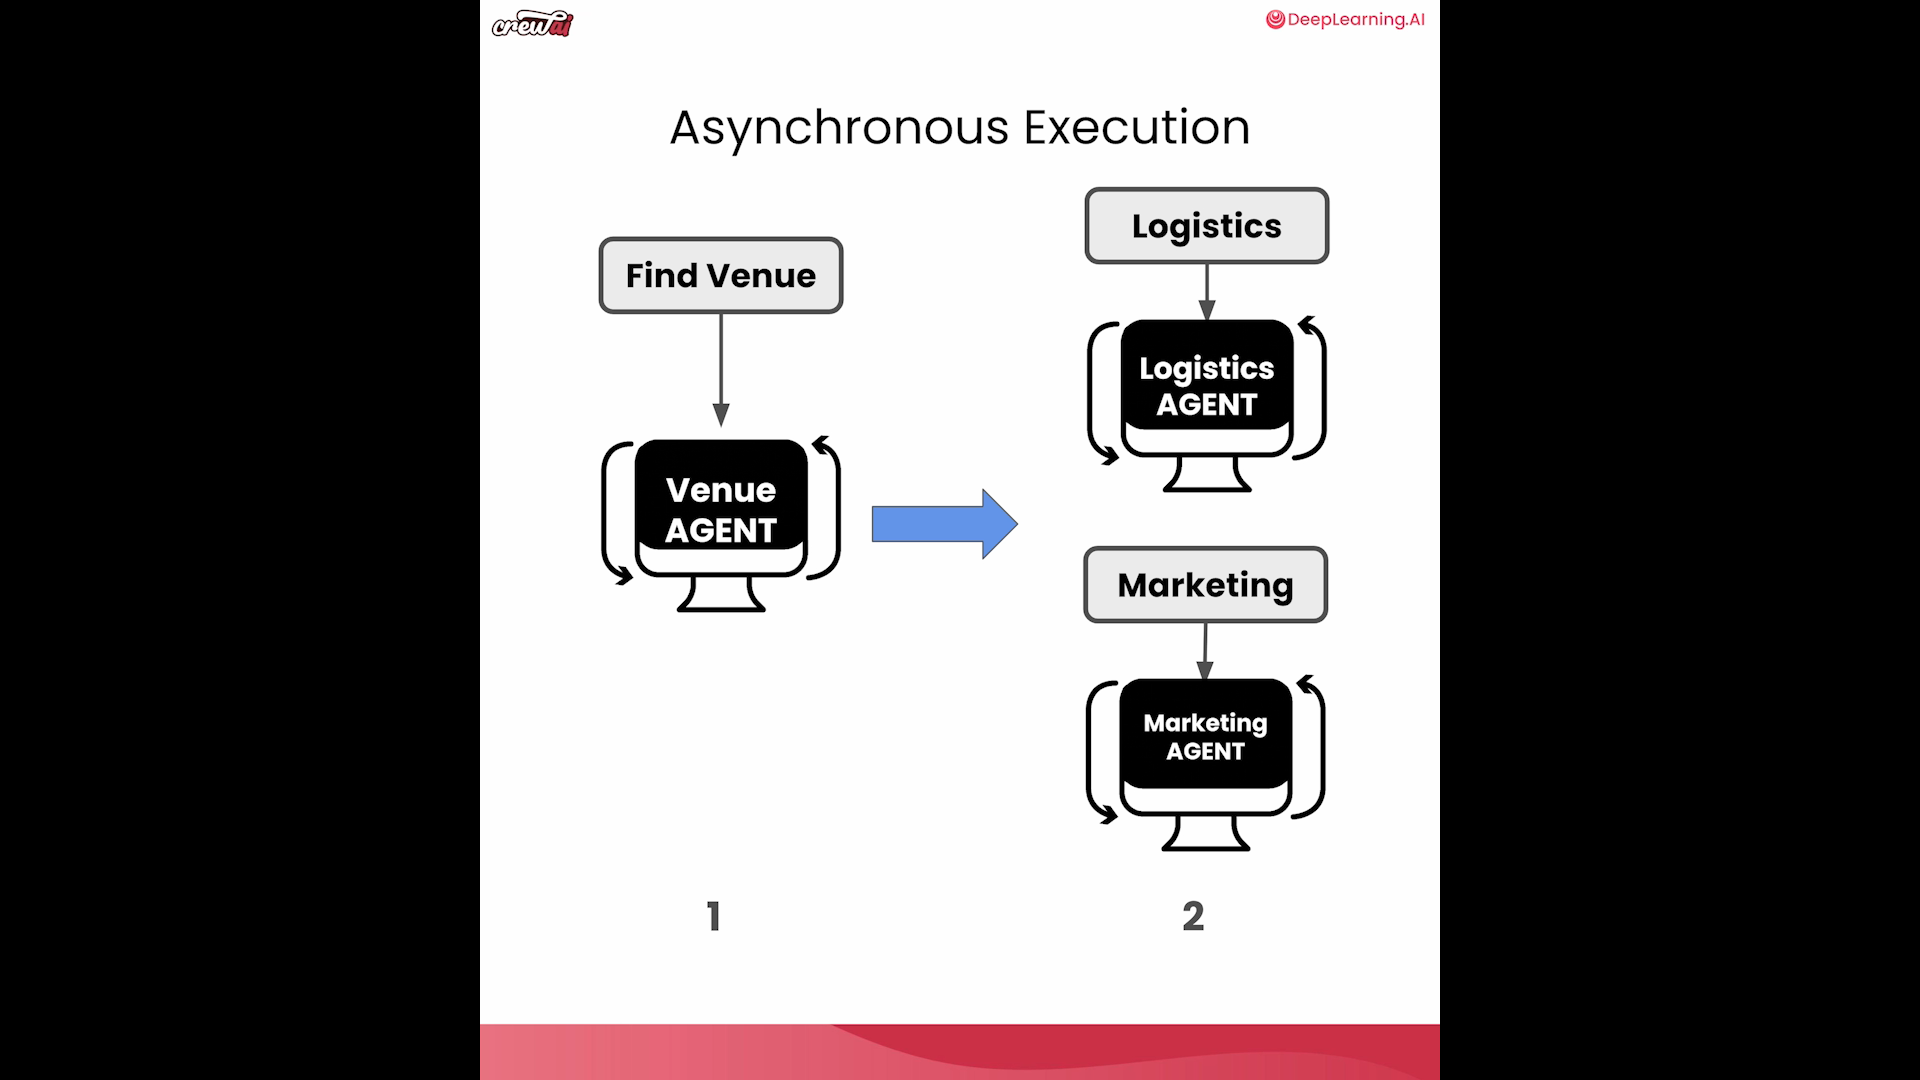

## Creating the Crew

**Note**: Since you set `async_execution=True` for `logistics_task` and `marketing_task` tasks, now the order for them does not matter in the `tasks` list.

In [12]:
# Define the crew with agents and tasks
event_management_crew = Crew(
    agents=[venue_coordinator, 
            logistics_manager, 
            marketing_communications_agent],
    
    tasks=[venue_task, 
           logistics_task, 
           marketing_task],
    
    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [13]:
event_details = {
    'event_topic': "Tech Innovation Conference",
    'event_description': "A gathering of tech innovators "
                         "and industry leaders "
                         "to explore future technologies.",
    'event_city': "San Francisco",
    'tentative_date': "2024-09-15",
    'expected_participants': 500,
    'budget': 20000,
    'venue_type': "Conference Hall"
}

**Note 1**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

**Note 2**: 
- Since you set `human_input=True` for some tasks, the execution will ask for your input before it finishes running.
- When it asks for feedback, use your mouse pointer to first click in the text box before typing anything.

In [20]:
result = event_management_crew.kickoff(inputs=event_details)

 [DEBUG]: == Working Agent: Venue Coordinator
 [INFO]: == Starting Task: Find a venue in San Francisco that meets criteria for Tech Innovation Conference.


> Entering new CrewAgentExecutor chain...
I need to find a suitable venue in San Francisco for the Tech Innovation Conference.

Action: Search the internet
Action Input: {"search_query": "venues for events in San Francisco"} 


Search results: Title: Top 20 Venues in San Francisco, CA - PartySlate
Link: https://www.partyslate.com/find-venues/near/san-francisco-ca-usa
Snippet: Top Venues in San Francisco ; The Westin St. Francis. 335 Powell St, San Francisco, CA 94102, USA. Spaces for 60-1,500 Guests. 8 Hotels. 8 Ballrooms ; 25 Lusk. 25 ...
---
Title: Party Venues near San Francisco, CA - Eventective
Link: https://www.eventective.com/san-francisco-ca/party-event-venues/
Snippet: Find and contact local Party Venues in San Francisco, CA with pricing and availability for your party event. Great for party planning!
---
Title: The 16 Bes

This is the agent final answer: Based on the search results and website content, the best venue in San Francisco for the Tech Innovation Conference would be the City View at METREON. This venue is located in the SoMa neighborhood, can accommodate up to 2,000 guests, and offers a versatile space with floor-to-ceiling windows, an expansive outdoor terrace, and a newly renovated ambiance. It is ideal for conferences, receptions, and special occasions. More information about the venue can be found at www.cityviewmetreon.com.
Please provide a feedback: yes , we can go ahead with this
Final Answer: 
After reassessing the information gathered, the best venue for the Tech Innovation Conference in San Francisco is the City View at METREON. Located in the SoMa neighborhood, this venue can accommodate up to 2,000 guests, offers a versatile space with floor-to-ceiling windows and an outdoor terrace, and has a newly renovated ambiance. It is an ideal choice for conferences, receptions, and special 

Final Answer: 
Based on my research, here is a list of potential marketing channels that we can use to promote the Tech Innovation Conference:

1. Online advertising
2. Conference website and event app
3. Social media
4. Email marketing
5. Influencer marketing
6. Search engine optimization (SEO)
7. Event listing websites

Each of these channels has proven to be effective in reaching new audiences and driving event registrations. The costs associated with each channel may vary, so a strategic approach is necessary to maximize the impact of our marketing efforts.

> Finished chain.
 

Based on my research, here is a list of potential marketing channels that we can use to promote the Tech Innovation Conference:

1. Online advertising
2. Conference website and event app
3. Social media
4. Email marketing
5. Influencer marketing
6. Search engine optimization (SEO)
7. Event listing websites

Each of these channels has proven to be effective in reaching new audiences and driving event registr

Exception in thread Thread-26 (_execute):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/local/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/site-packages/crewai/task.py", line 182, in _execute
    result = agent.execute_task(
             ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/crewai/agent.py", line 221, in execute_task
    result = self.agent_executor.invoke(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/langchain/chains/base.py", line 163, in invoke
    raise e
  File "/usr/local/lib/python3.11/site-packages/langchain/chains/base.py", line 153, in invoke
    self._call(inputs, run_manager=run_manager)
  File "/u

Thought: 
I need to effectively market the Tech Innovation Conference to engage at least 500 potential attendees. 

Action: Delegate work to co-worker
Action Input: {
  "coworker": "Logistics Manager",
  "task": "Research potential marketing channels for the conference",
  "context": "I need you to research and provide a list of potential marketing channels that we can use to promote the Tech Innovation Conference to reach at least 500 potential attendees. Please include details on the effectiveness and cost of each channel."
} 

Based on my research, here is a list of potential marketing channels that we can use to promote the Tech Innovation Conference:

1. Online advertising
2. Conference website and event app
3. Social media
4. Email marketing
5. Influencer marketing
6. Search engine optimization (SEO)
7. Event listing websites

Each of these channels has proven to be effective in reaching new audiences and driving event registrations. The costs associated with each channel may var

- Display the generated `venue_details.json` file.

In [21]:
import json
from pprint import pprint

with open('venue_details.json') as f:
   data = json.load(f)

pprint(data)

{'address': 'SoMa neighborhood, San Francisco',
 'booking_status': 'Available',
 'capacity': 2000,
 'name': 'City View at METREON'}


- Display the generated `marketing_report.md` file.

**Note**: After `kickoff` execution has successfully ran, wait an extra 45 seconds for the `marketing_report.md` file to be generated. If you try to run the code below before the file has been generated, your output would look like:

```
marketing_report.md
```

If you see this output, wait some more and than try again.

In [22]:
from IPython.display import Markdown
Markdown("marketing_report.md")

## Tech Innovation Conference Marketing Report

### Marketing Channels:
Based on research conducted, the following marketing channels have been identified as potential options to promote the Tech Innovation Conference and engage at least 500 potential attendees:

1. **Online Advertising**: Utilize targeted online ads to reach a broader audience interested in tech innovation.
   
2. **Conference Website and Event App**: Optimize the conference website and app to provide comprehensive information and registration options.
   
3. **Social Media**: Leverage social media platforms to create buzz, share updates, and engage with the tech community.
   
4. **Email Marketing**: Send targeted emails to potential attendees, sponsors, and partners to increase event awareness.
   
5. **Influencer Marketing**: Collaborate with industry influencers to promote the conference and attract their followers.
   
6. **Search Engine Optimization (SEO)**: Improve search engine rankings to ensure the conference is easily discoverable online.
   
7. **Event Listing Websites**: Utilize event listing platforms to expand reach and attract individuals interested in tech events.

### Venue Information:
The Tech Innovation Conference will be held at **City View at METREON** located in the SoMa neighborhood of San Francisco. The venue offers over 31,000 square feet of divisible space with a breathtaking view of the city skyline and an outdoor terrace. The address is 135 Fourth Street, Suite 4000, San Francisco, CA 94103.

For more details and booking information, please visit [City View at METREON](https://www.cityviewmetreon.com/).

By implementing a strategic marketing plan using the identified channels and leveraging the unique features of the venue, we aim to successfully promote the conference and achieve our goal of engaging over 500 attendees.